In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-none-any.whl size=18733 sha256=ddf060fbe09d2f6fce5fd9449fcc39ef1e52d4820a46d65fa28a6e7cd35cd91c
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Created wheel for absl-py: filename=absl_py-0.8.0-cp36-none-any.whl size=116857 sha256=68eb77951e965a7437233dc1064741eec1dceec8df78f7db4618bfc7fd2ee3de
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\9a\1e\7a\456008eb5e47fd5de792c6139df6d5b3d5f71d51c6a0b94799
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4006 sha256=ed4f10f1012d183622511ddc7d2dc8fe9f26f8d332351a49878c1b6639582378
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=6594 sha256=84cb972abdcbd2dcf48322e07e4516ad18db01007ea273a39d45798c9a4ea1c

ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.17.1)


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\k8958\AppData\Roaming\Python\Python37\site-

# Model Building

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [4]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    
    ITM_df = sample_df[sample_df['moneyness'] <= 0.97]
    ATM_df = sample_df[sample_df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = sample_df[sample_df['moneyness'] >= 1.03]
    
    return sample_df, ITM_df, ATM_df, OTM_df

In [5]:
sample_df, ITM_df, ATM_df, OTM_df = load_data('Options_R_new.csv')

In [7]:
print('option data shape:', sample_df.shape)
print('In-The_Money option data shape:', ITM_df.shape)
print('An-The_Money option data shape:', ATM_df.shape)
print('Out-The_Money option data shape:', OTM_df.shape)

option data shape: (1700235, 11)
In-The_Money option data shape: (687300, 11)
An-The_Money option data shape: (262052, 11)
Out-The_Money option data shape: (750883, 11)


In [8]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

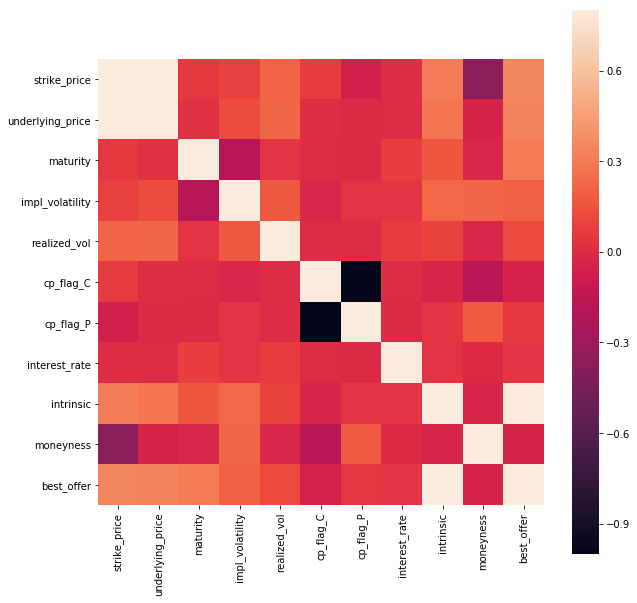

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [46]:
corr = get_corr(sample_df)

In [6]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['intrinsic', 'strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_P', 'interest_rate']]
    
    sc_X = StandardScaler()
    sc_X.fit(X)
    X_scale = sc_X.fit_transform(X)

    sc_y = StandardScaler()
    y = y.reshape(-1,1)
    sc_y.fit(y)
    y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scale, y_scale, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, sc_X, sc_y

## Build model with in-the-money option data

In [7]:
X_train_ITM, X_test_ITM, y_train_ITM, y_test_ITM, sc_X_ITM, sc_y_ITM = data(ITM_df.sample(frac=0.8))

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
y_test_ITM[:10]

array([[-0.55074404],
       [-0.52245578],
       [-0.50022929],
       [-0.54737639],
       [-0.5184146 ],
       [-0.54198815],
       [-0.53255873],
       [-0.5520911 ],
       [ 0.09719185],
       [-0.52649696]])

In [8]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def ABS(x):
    return K.abs(x)

def exp(x):
    return K.exp(x)

In [9]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = 'linear'))
    
    #optimizer = Adam()
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.figure(figsize = (14, 10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 395884 samples, validate on 43988 samples
Epoch 1/200
395884/395884 [==============================] - 13s 32us/step - loss: 0.0484 - mean_absolute_error: 0.1305 - val_loss: 0.1338 - val_mean_absolute_error: 0.1865
Epoch 2/200
395884/395884 [==============================] - 12s 31us/step - loss: 0.0179 - mean_absolute_error: 0.0811 - val_loss: 0.1261 - val_mean_absolute_error: 0.1643
Epoch 3/200
395884/395884 [==============================] - 12s 30us/step - loss: 0.0133 - mean_absolute_error: 0.0690 - val_loss: 0.1141 - val_mean_absolute_error: 0.1495
Epoch 4/200
395884/395884 [==============================] - 12s 30us/step - loss: 0.0114 - mean_absolute_error: 0.0631 - val_loss: 0.1143 - val_mean_absolute_error: 0.1512
Epoch 5/200
395884/395884 [==============================] - 12s 30us/step - loss: 0.0099 - mean_absolute_error: 0.0587 - val_loss: 0.08

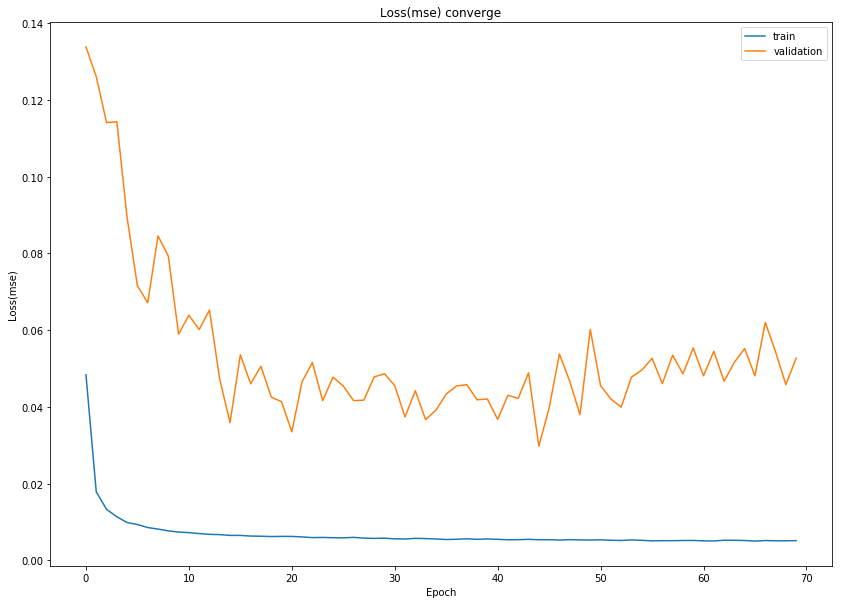

Wall time: 13min 46s


In [13]:
%time model_ITM, result_ITM = create_model(X_train_ITM, y_train_ITM)

In [10]:
def pred(model, X, y, sc_X, sc_y):
    
    pred = model.predict(X)

    pred = sc_y.inverse_transform(pred)
    y = sc_y.inverse_transform(y)

    pred = pred.flatten()
    y = y.flatten()

    d = {'predicted': pred, 'actual': y}
    pred_df = pd.DataFrame(data = d)
    display(pred_df.head(10))

    pred_sample = pred_df.sample(n = 150)

    pred_sample.sort_index(axis = 0, inplace = True)
    
    plt.figure(1, figsize = (15,10))
    plt.plot(pred_sample.index, pred_sample['predicted'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(pred_sample.index, pred_sample['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    l,binEdges=np.histogram(np.abs(pred_sample['predicted']-pred_sample['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
    
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist(pred_df['predicted']-pred_df['actual'], 8, range = (-4,4),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30)  

    print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y,pred))
    print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y,pred))
    print("R square (R^2):            %f" % skm.r2_score(y,pred))

W0829 02:09:28.733952  3992 deprecation_wrapper.py:119] From C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 02:09:28.763878  3992 deprecation_wrapper.py:119] From C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 02:09:28.833661  3992 deprecation_wrapper.py:119] From C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 02:09:28.834658  3992 deprecation_wrapper.py:119] From C:\Users\k8958\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto inste

,predicted,actual
0,1.070641,1.16
1,0.078522,0.10
2,0.008094,0.03
3,5.550483,5.40
4,0.050501,0.03
5,87.365211,87.00
6,0.167736,0.19
7,0.105079,0.11
8,4.450653,4.50
9,29.757898,30.00


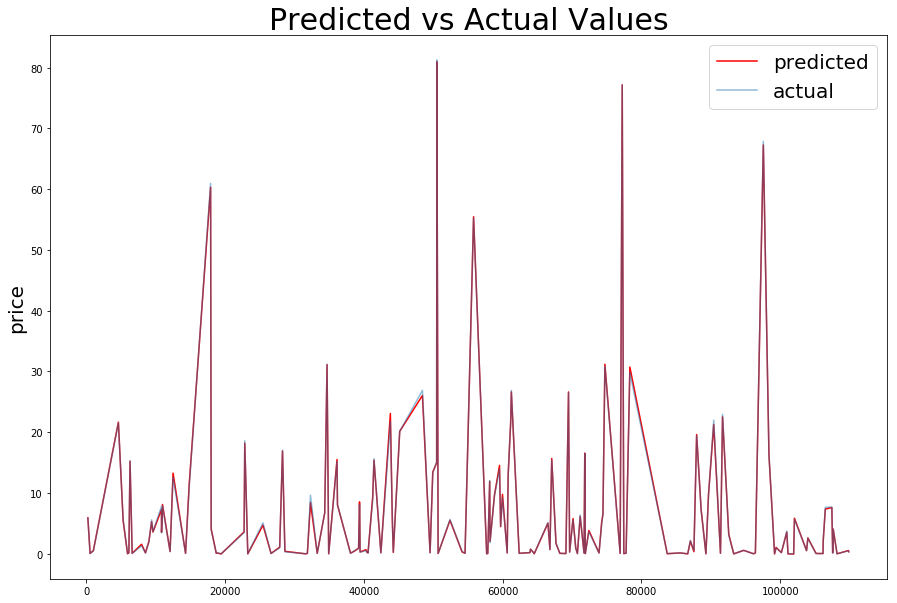

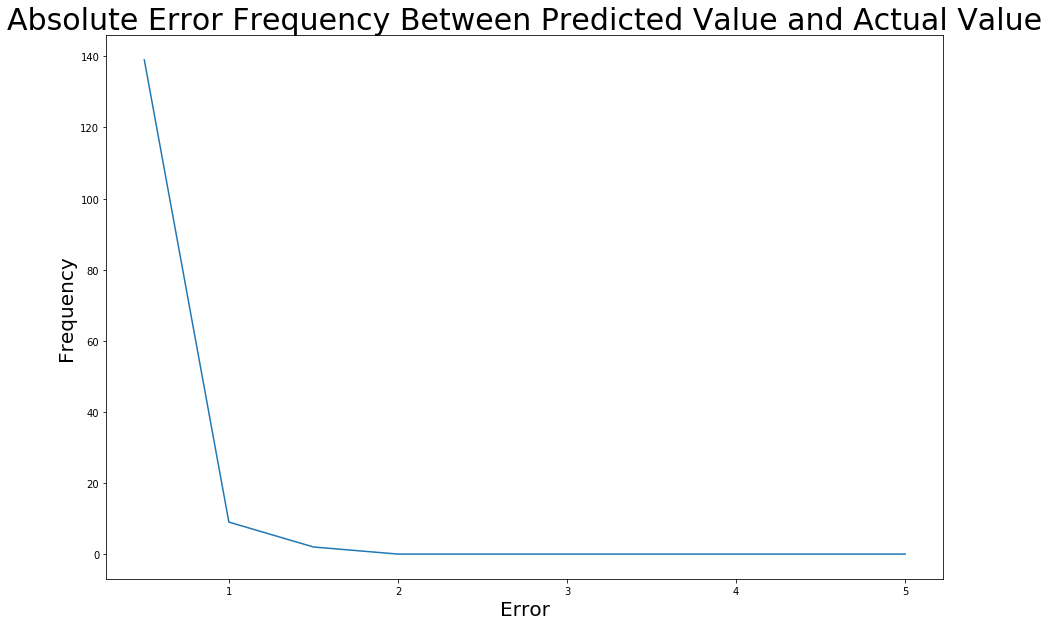

Mean absolute error (MAE): 0.146261
Mean squared error (MSE):  0.075608
R square (R^2):            0.999654


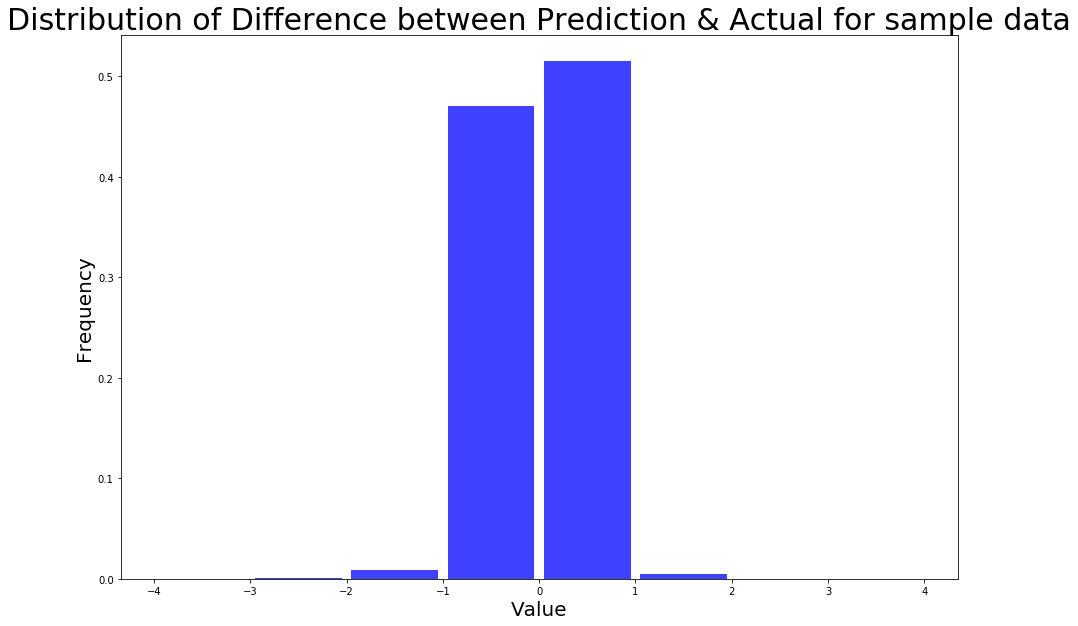

In [11]:
model_ITM = load_model('model4_2_ITM.h5')
pred_ITM = pred(model_ITM, X_test_ITM, y_test_ITM, sc_X_ITM, sc_y_ITM)

In [29]:
model_ITM.save('model4_2_ITM.h5')

## Build model with at-the-money option data

In [12]:
X_train_ATM, X_test_ATM, y_train_ATM, y_test_ATM, sc_X_ATM, sc_y_ATM = data(ATM_df)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Train on 188676 samples, validate on 20965 samples
Epoch 1/200
188676/188676 [==============================] - 4s 20us/step - loss: 0.0396 - mean_absolute_error: 0.1186 - val_loss: 0.0142 - val_mean_absolute_error: 0.0836
Epoch 2/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0111 - mean_absolute_error: 0.0752 - val_loss: 0.0094 - val_mean_absolute_error: 0.0694
Epoch 3/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0091 - mean_absolute_error: 0.0686 - val_loss: 0.0091 - val_mean_absolute_error: 0.0680
Epoch 4/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0078 - mean_absolute_error: 0.0635 - val_loss: 0.0069 - val_mean_absolute_error: 0.0599
Epoch 5/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.0067 - mean_absolute_error: 0.0588 - val_loss: 0.0071 - val_mean_absolute_error: 0.0588
Epoch 6/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0062 

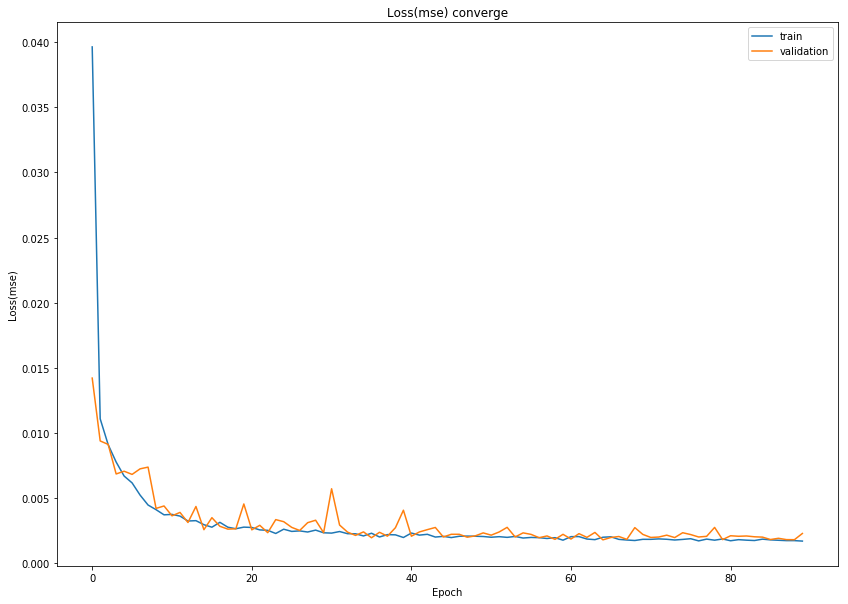

Wall time: 4min 47s


In [31]:
%time model_ATM, result_ATM = create_model(X_train_ATM, y_train_ATM)

,predicted,actual
0,1.019634,0.88
1,1.885182,1.93
2,7.741723,7.70
3,3.521615,3.45
4,0.568279,0.62
5,0.555335,0.59
6,1.345060,1.38
7,0.553710,0.53
8,2.419146,2.49
9,0.342828,0.44


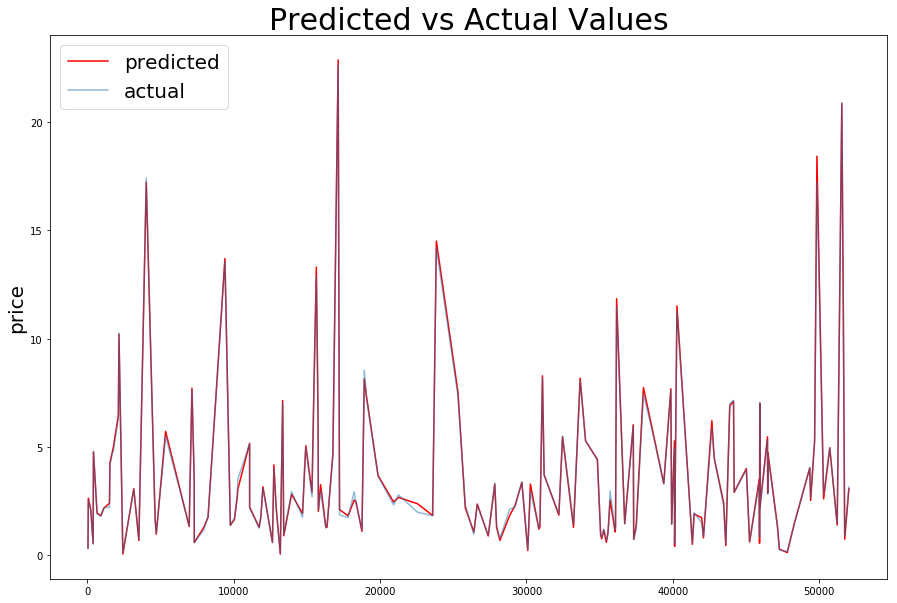

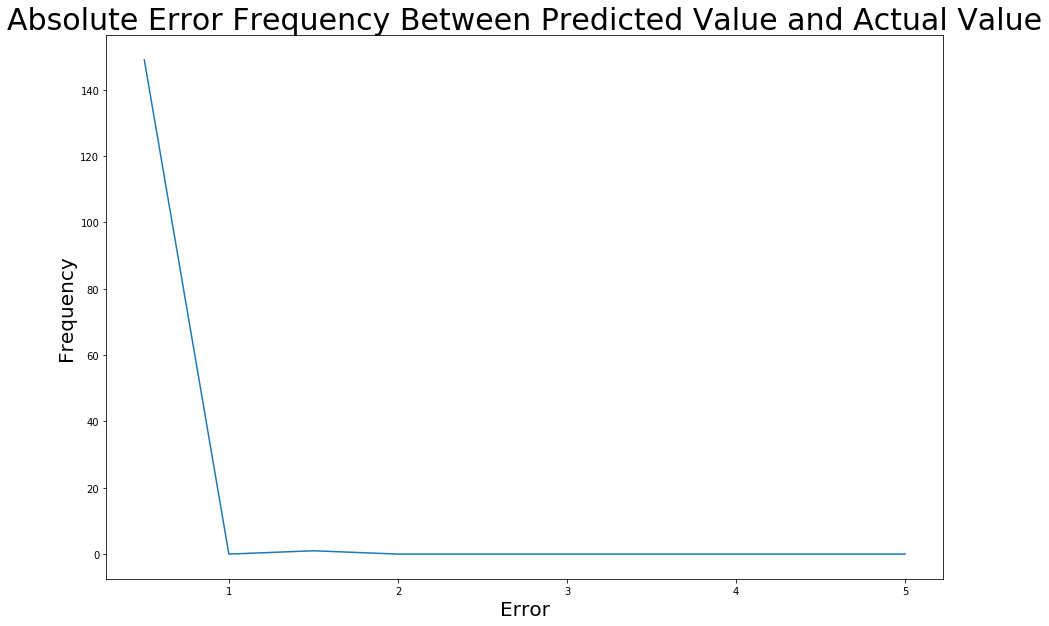

Mean absolute error (MAE): 0.115261
Mean squared error (MSE):  0.031142
R square (R^2):            0.997678


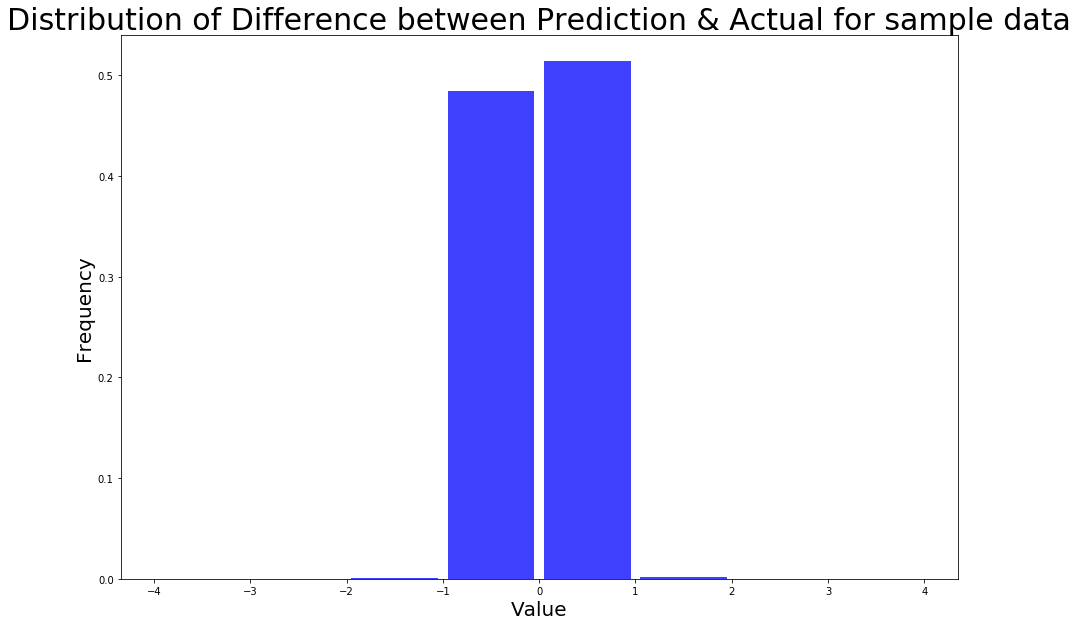

In [14]:
model_ATM = load_model('model4_2_ATM.h5')
pred_ATM = pred(model_ATM, X_test_ATM, y_test_ATM, sc_X_ATM, sc_y_ATM)

In [33]:
model_ATM.save('model4_2_ATM.h5')

## Build model with out-the-money option data

In [17]:
X_train_OTM, X_test_OTM, y_train_OTM, y_test_OTM, sc_X_OTM, sc_y_OTM = data(OTM_df.sample(frac=0.8))

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Train on 432507 samples, validate on 48057 samples
Epoch 1/200
432507/432507 [==============================] - 8s 18us/step - loss: 0.0094 - mean_absolute_error: 0.0453 - val_loss: 0.0023 - val_mean_absolute_error: 0.0308
Epoch 2/200
432507/432507 [==============================] - 7s 17us/step - loss: 0.0012 - mean_absolute_error: 0.0228 - val_loss: 0.0011 - val_mean_absolute_error: 0.0220
Epoch 3/200
432507/432507 [==============================] - 8s 17us/step - loss: 9.3864e-04 - mean_absolute_error: 0.0199 - val_loss: 9.2801e-04 - val_mean_absolute_error: 0.0204
Epoch 4/200
432507/432507 [==============================] - 7s 16us/step - loss: 8.8333e-04 - mean_absolute_error: 0.0191 - val_loss: 9.0742e-04 - val_mean_absolute_error: 0.0186
Epoch 5/200
432507/432507 [==============================] - 7s 17us/step - loss: 8.8012e-04 - mean_absolute_error: 0.0189 - val_loss: 7.3131e-04 - val_mean_absolute_error: 0.0172
Epoch 6/200
432507/432507 [==============================] - 7s 1

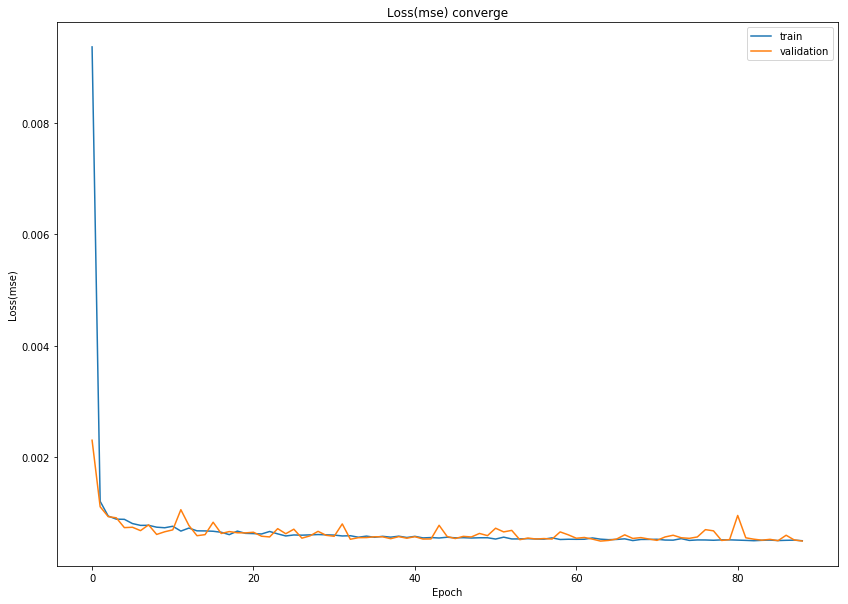

Wall time: 10min 37s


In [35]:
%time model_OTM, result_OTM = create_model(X_train_OTM, y_train_OTM)

In [18]:
model_OTM = load_model('model4_2_OTM.h5')

,predicted,actual
0,1.934086,1.98
1,0.201557,0.16
2,3.104304,3.05
3,0.102317,0.06
4,0.419652,0.59
5,17.768574,17.75
6,2.276129,2.30
7,0.797349,0.72
8,0.229168,0.21
9,19.729580,19.80


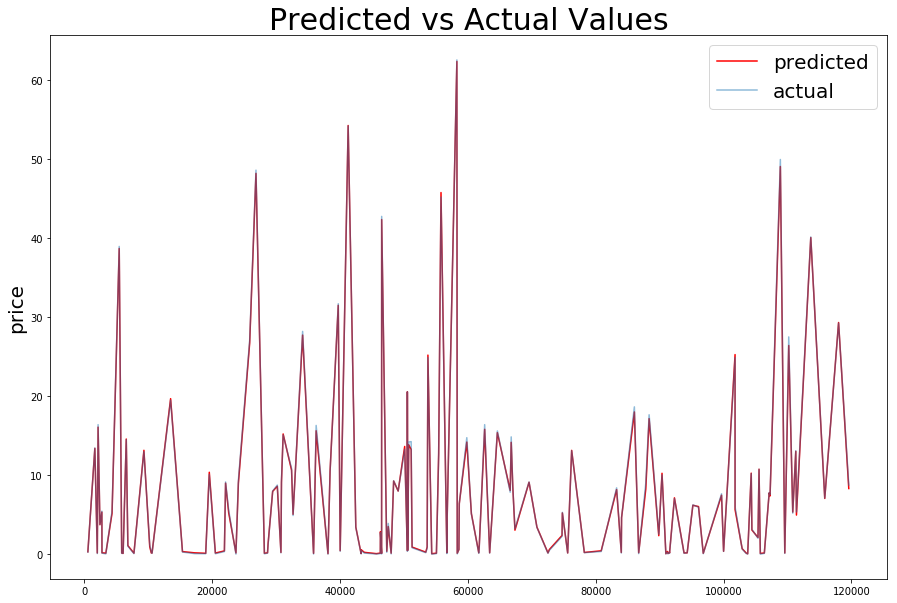

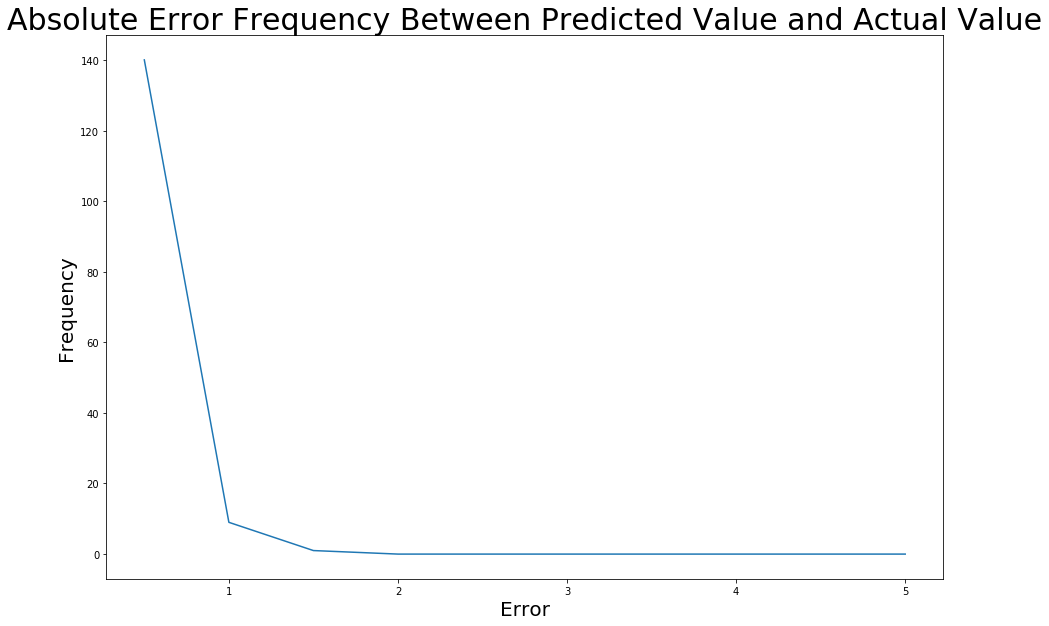

Mean absolute error (MAE): 0.152555
Mean squared error (MSE):  0.066360
R square (R^2):            0.999423


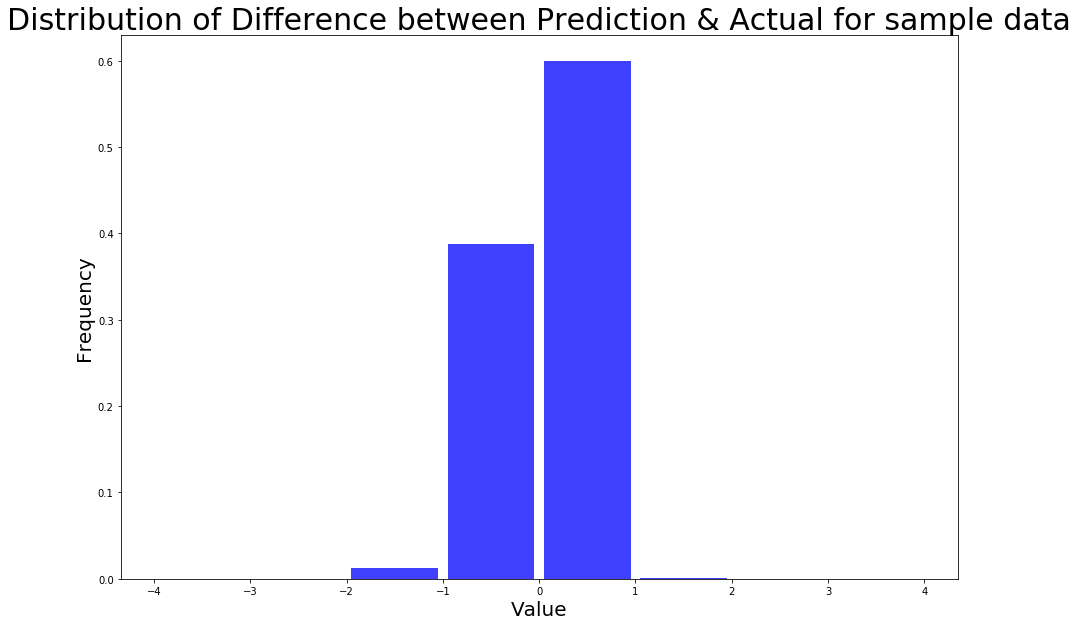

In [19]:
pred_OTM = pred(model_OTM, X_test_OTM, y_test_OTM, sc_X_OTM, sc_y_OTM)

In [37]:
model_OTM.save('model4_2_OTM.h5')

## Build model with whole option data

In [20]:
X_train, X_test, y_train, y_test, sc_X, sc_y = data(sample_df.sample(frac=0.7))

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
%time model, result = create_model(X_train, y_train)

Train on 856917 samples, validate on 95214 samples
Epoch 1/200
856917/856917 [==============================] - 8s 9us/step - loss: 0.0081 - mean_absolute_error: 0.0419 - val_loss: 0.0011 - val_mean_absolute_error: 0.0221
Epoch 2/200
530432/856917 [=================>............] - ETA: 2s - loss: 0.0011 - mean_absolute_error: 0.0228

KeyboardInterrupt: 

,predicted,actual
0,23.999655,24.30
1,7.315892,7.00
2,0.181061,0.12
3,10.310371,9.95
4,14.397700,14.40
5,0.913757,0.98
6,0.252454,0.21
7,88.541626,89.85
8,0.447699,0.54
9,2.482444,2.32


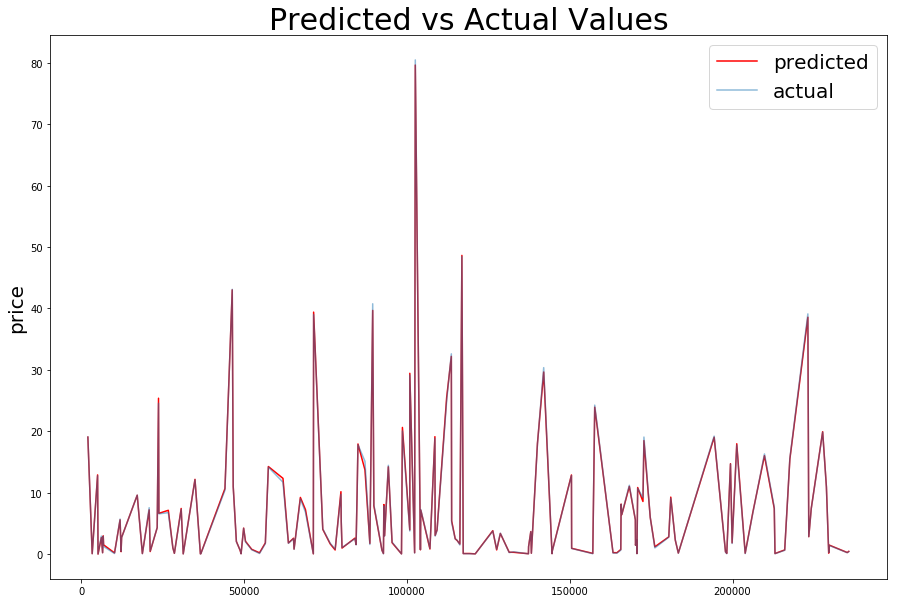

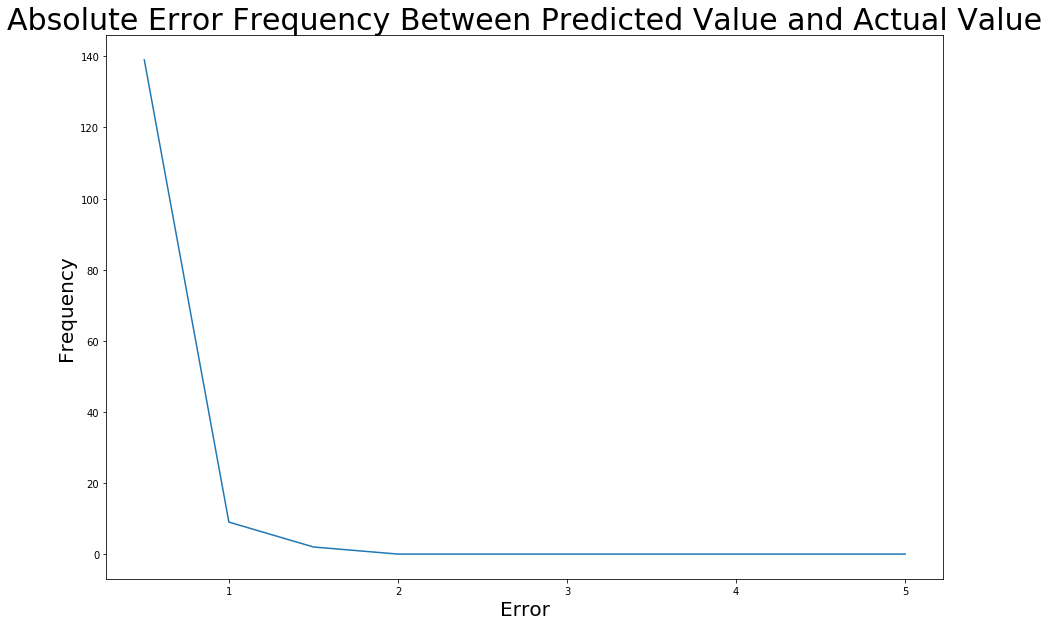

Mean absolute error (MAE): 0.147886
Mean squared error (MSE):  0.078865
R square (R^2):            0.999459


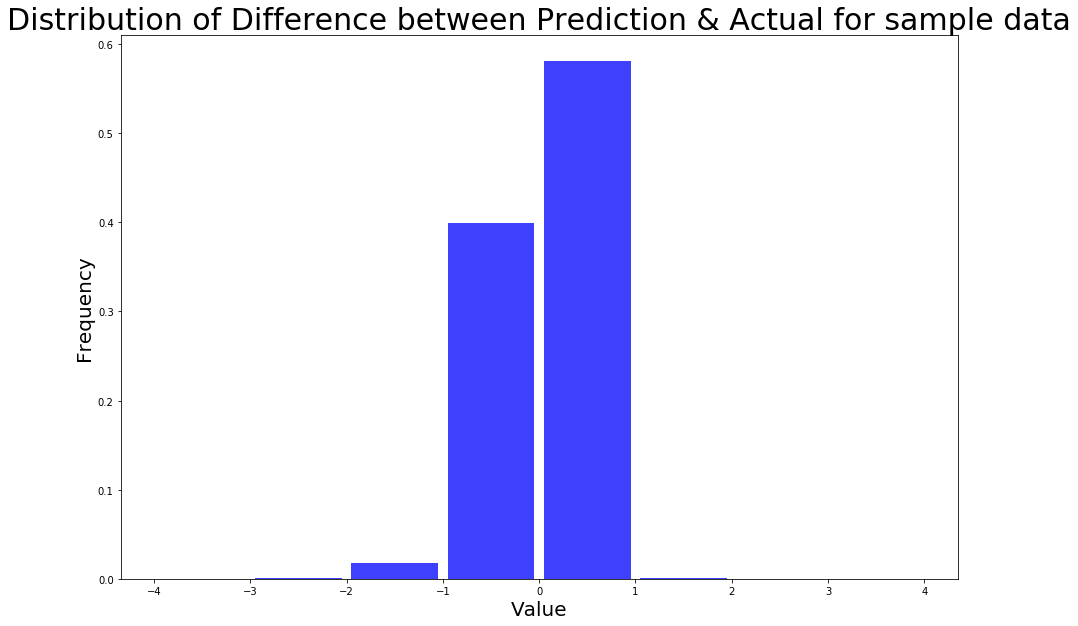

In [23]:
pred = pred(model, X_test, y_test, sc_X, sc_y)

In [24]:
model.save('model4_2_whole.h5')

# Prediction

We use the three models we built above to do option price prediction. In the above, the train and test dataset were generated from the same dataset, even though they were splited randomly, the data structures were very similar. In this section, we want to apply the models to out of sample data which is in different time range from the data used to train the model to check our models' robustness. 

In [25]:
def load_prediction_data():
    df = pd.read_csv('Options_R_test.csv')
    df = df.dropna()
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    #sample_df = sample_df.reset_index(drop=True)
    ITM_df = df[df['moneyness'] <= 0.97]
    ATM_df = df[df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = df[df['moneyness'] >= 1.03]
    
    return df, ITM_df, ATM_df, OTM_df

In [26]:
p_df, p_df_ITM, p_df_ATM, p_df_OTM = load_prediction_data()

In [42]:
def model_pred(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
    sc_X = StandardScaler()
    sc_X.fit(X)
    X_scale = sc_X.transform(X)

    sc_y = StandardScaler()
    y = y.reshape(-1,1)
    sc_y.fit(y)
    y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X_scale)
    
    pred = pred.flatten()
    y_scale = y_scale.flatten()
    y = y.flatten()
    y_pred = sc_y.inverse_transform(pred)
    
    d = {'predicted_scale': pred, 'actual_scale': y_scale, 'predict': y_pred, 'actual':y}
    datanew = pd.DataFrame(data = d)
    display(datanew.head(10))
      
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)
    
    plt.figure(1, figsize = (15,10))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    l,binEdges=np.histogram(np.abs(sample_data['predict']-sample_data['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
    
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist(datanew['predict']-datanew['actual'], 8, range = (-4,4),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    
    
    #print("Average sum error:              %f" % mean_sum_error(y, y_pred))
    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, y_pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, y_pred))
    #print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, y_pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, y_pred))

## Predict in-the-money option data

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.543691,-0.479154,-1.034642,0.13
1,-0.543048,-0.479154,-1.023041,0.13
2,-0.485228,-0.483033,0.020389,0.06
3,-0.489570,-0.484141,-0.057975,0.04
4,-0.492674,-0.484695,-0.113990,0.03
5,-0.498156,-0.484695,-0.212909,0.03
6,-0.496676,-0.484695,-0.186207,0.03
7,-0.504699,-0.485249,-0.330986,0.02
8,-0.502932,-0.483033,-0.299104,0.06
9,-0.507284,-0.483587,-0.377629,0.05


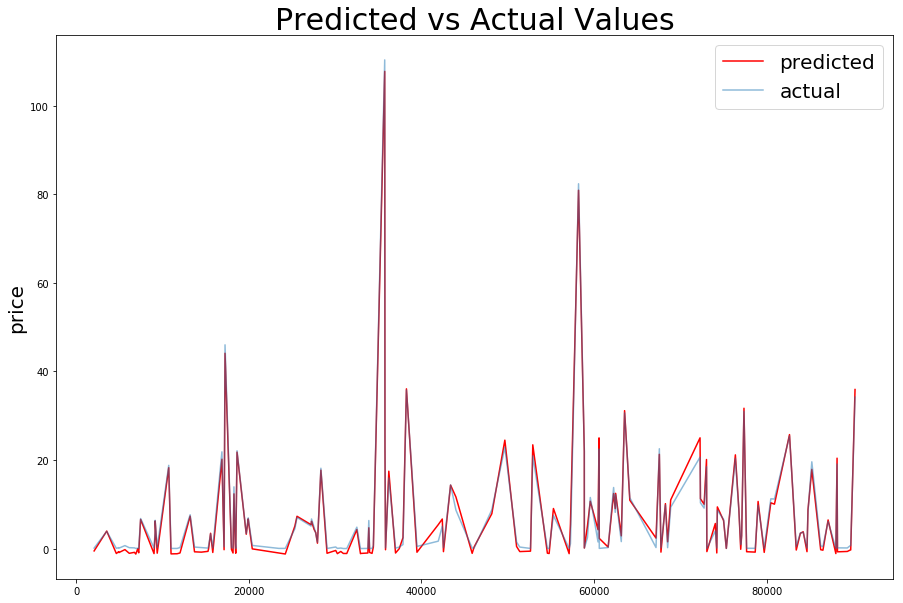

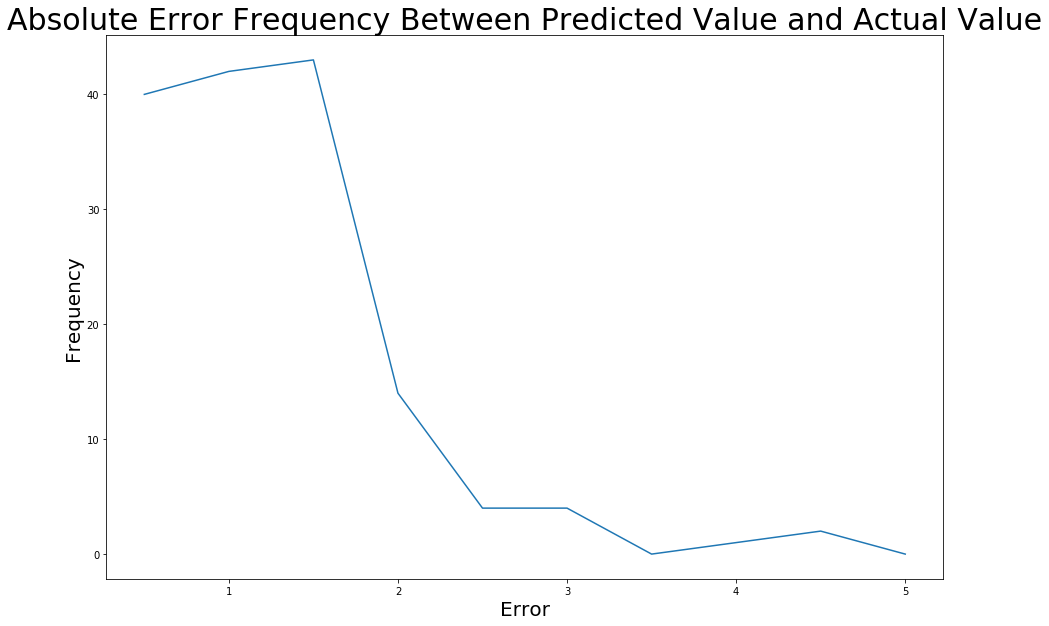

Mean absolute error (MAE):      1.050992
Mean squared error (MSE):       1.837540
R square (R^2):                 0.994358


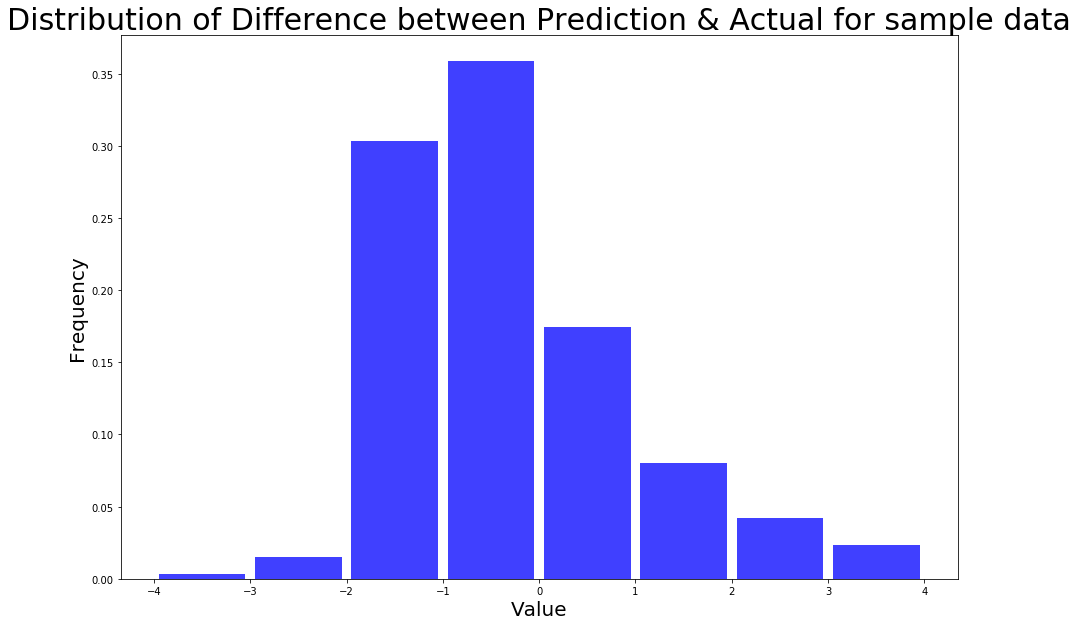

In [43]:
model_pred(p_df_ITM, model_ITM, 'impl_volatility')

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.547980,-0.479154,-1.112036,0.13
1,-0.540830,-0.479154,-0.983007,0.13
2,-0.502122,-0.483033,-0.284479,0.06
3,-0.508497,-0.484141,-0.399521,0.04
4,-0.514656,-0.484695,-0.510676,0.03
5,-0.519447,-0.484695,-0.597138,0.03
6,-0.524023,-0.484695,-0.679708,0.03
7,-0.528289,-0.485249,-0.756690,0.02
8,-0.532001,-0.483033,-0.823690,0.06
9,-0.535468,-0.483587,-0.886255,0.05


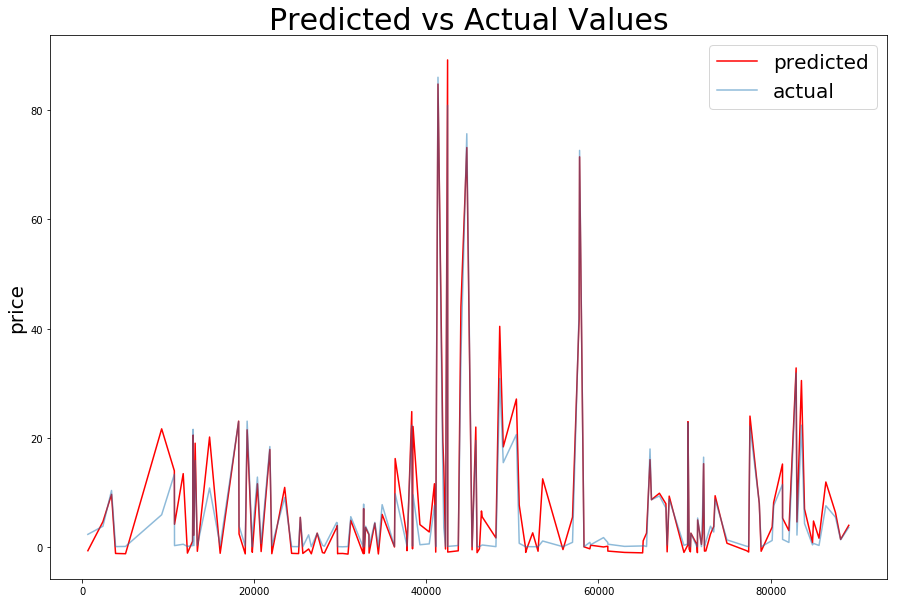

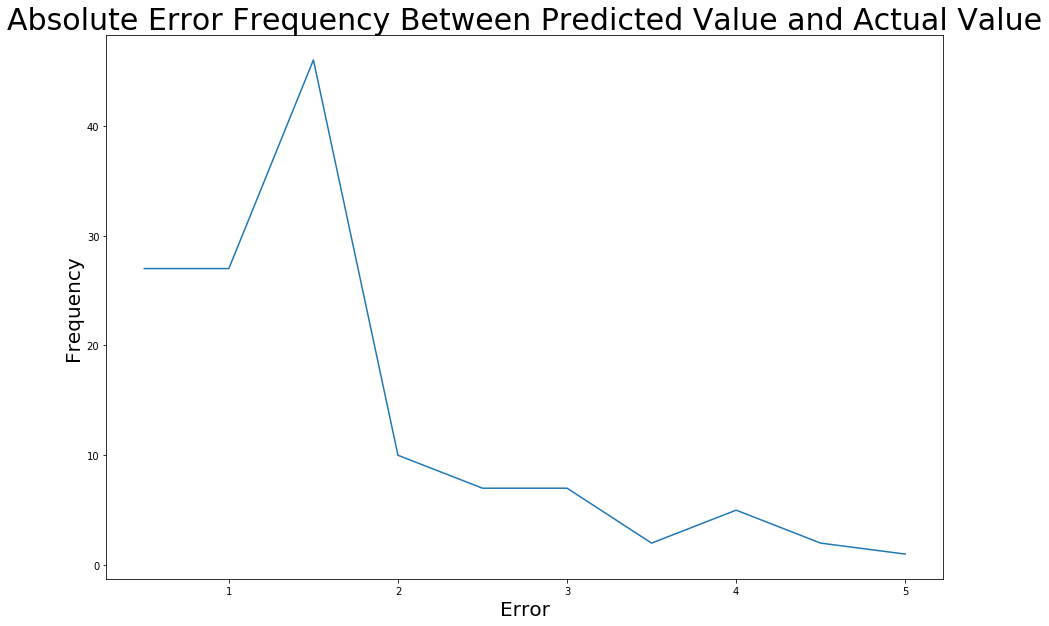

Mean absolute error (MAE):      2.069871
Mean squared error (MSE):       11.242350
R square (R^2):                 0.965479


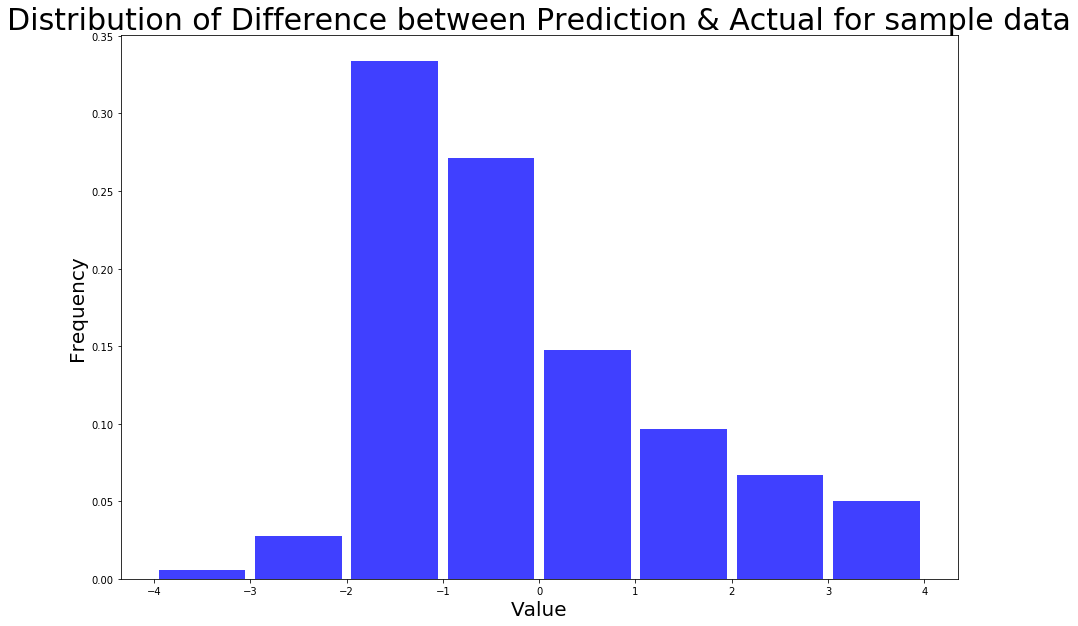

In [44]:
model_pred(p_df_ITM, model_ITM, 'realized_vol')

## Predict at-the-money option data

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.238249,-0.398395,2.239437,1.70
1,-0.334546,-0.514176,1.915069,1.31
2,-0.452487,-0.621052,1.517795,0.95
3,-0.566476,-0.707145,1.133833,0.66
4,-0.628118,-0.772458,0.926199,0.44
5,-0.672928,-0.819958,0.775259,0.28
6,-0.714964,-0.852614,0.633665,0.17
7,-0.750519,-0.873396,0.513900,0.10
8,-0.632482,-0.802146,0.911499,0.34
9,-0.584947,-0.760583,1.071615,0.48


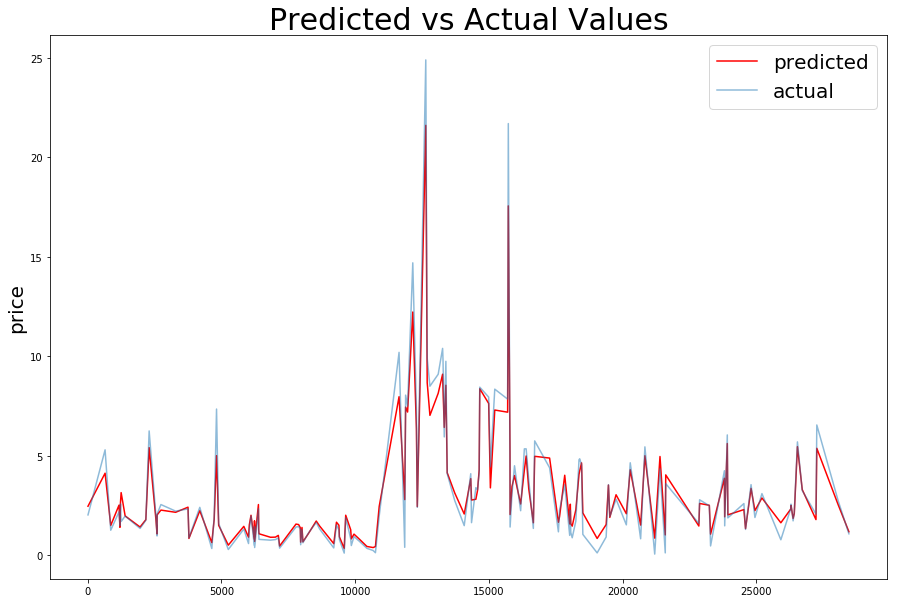

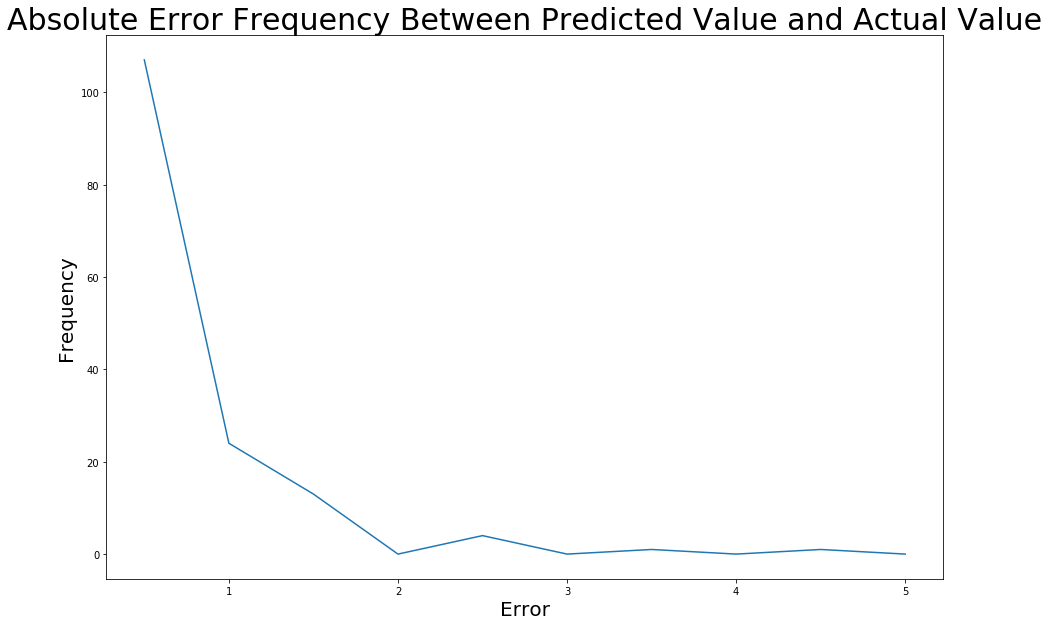

Mean absolute error (MAE):      0.423143
Mean squared error (MSE):       0.480289
R square (R^2):                 0.957670


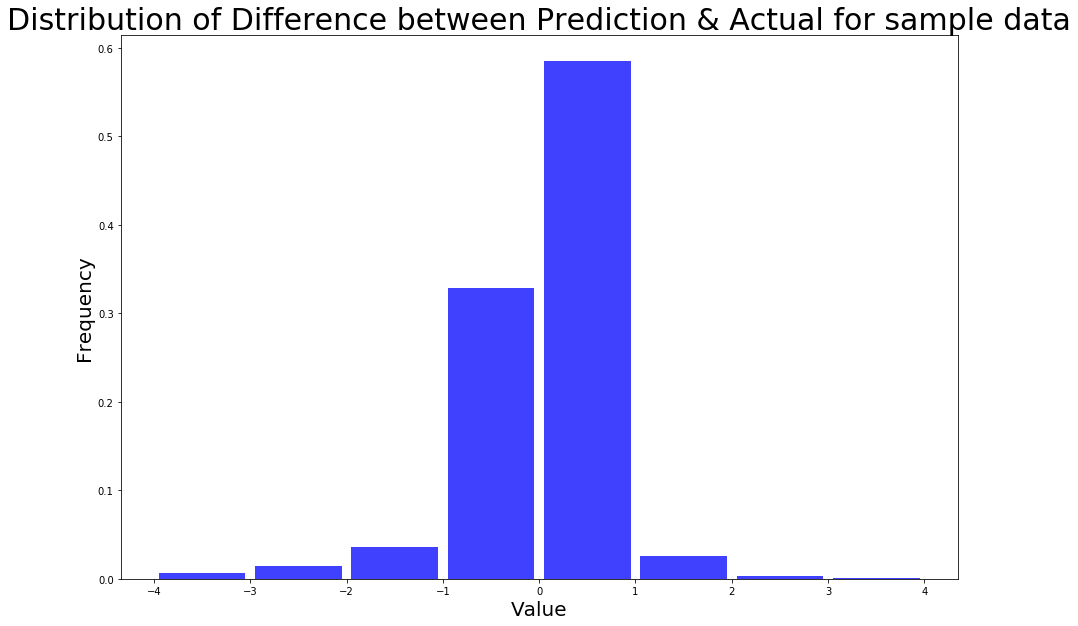

In [45]:
model_pred(p_df_ATM, model_ATM, 'impl_volatility')

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.244036,-0.398395,2.219946,1.70
1,-0.361350,-0.514176,1.824783,1.31
2,-0.473392,-0.621052,1.447377,0.95
3,-0.577518,-0.707145,1.096638,0.66
4,-0.639913,-0.772458,0.886467,0.44
5,-0.682375,-0.819958,0.743437,0.28
6,-0.721953,-0.852614,0.610121,0.17
7,-0.760376,-0.873396,0.480696,0.10
8,-0.695977,-0.802146,0.697619,0.34
9,-0.665297,-0.760583,0.800965,0.48


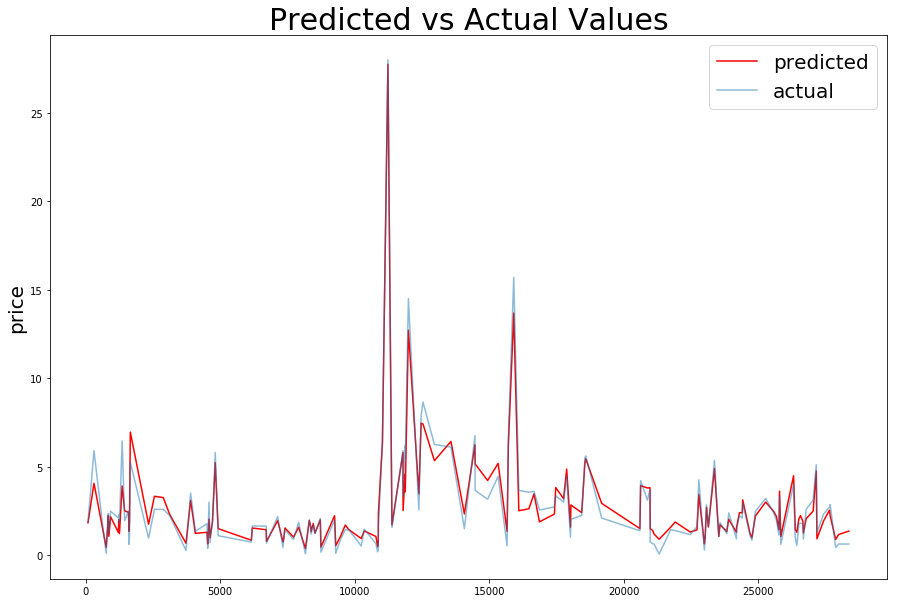

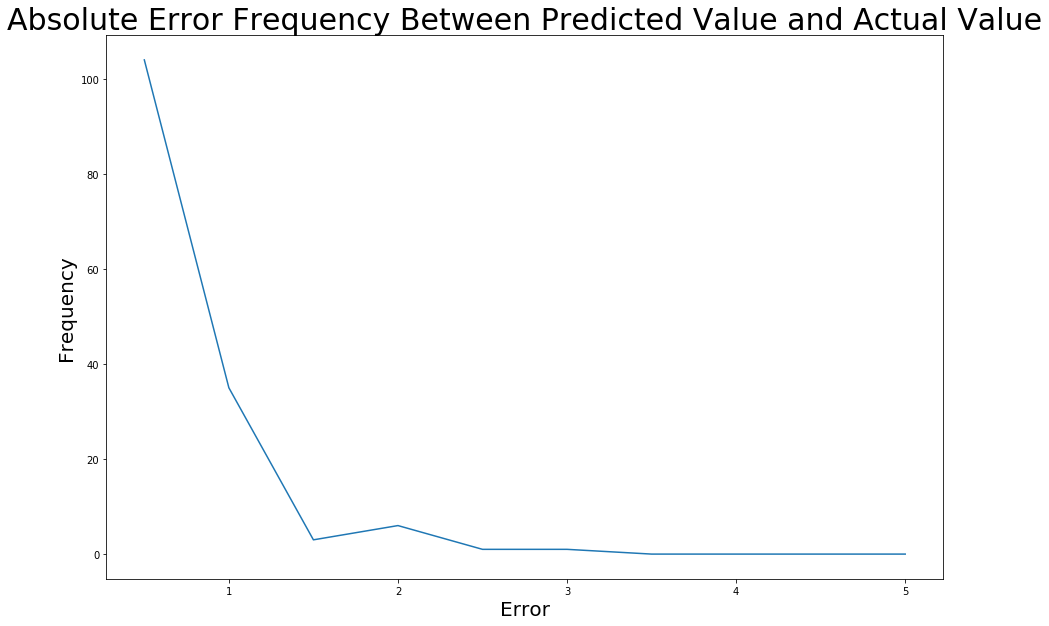

Mean absolute error (MAE):      0.509305
Mean squared error (MSE):       0.511314
R square (R^2):                 0.954935


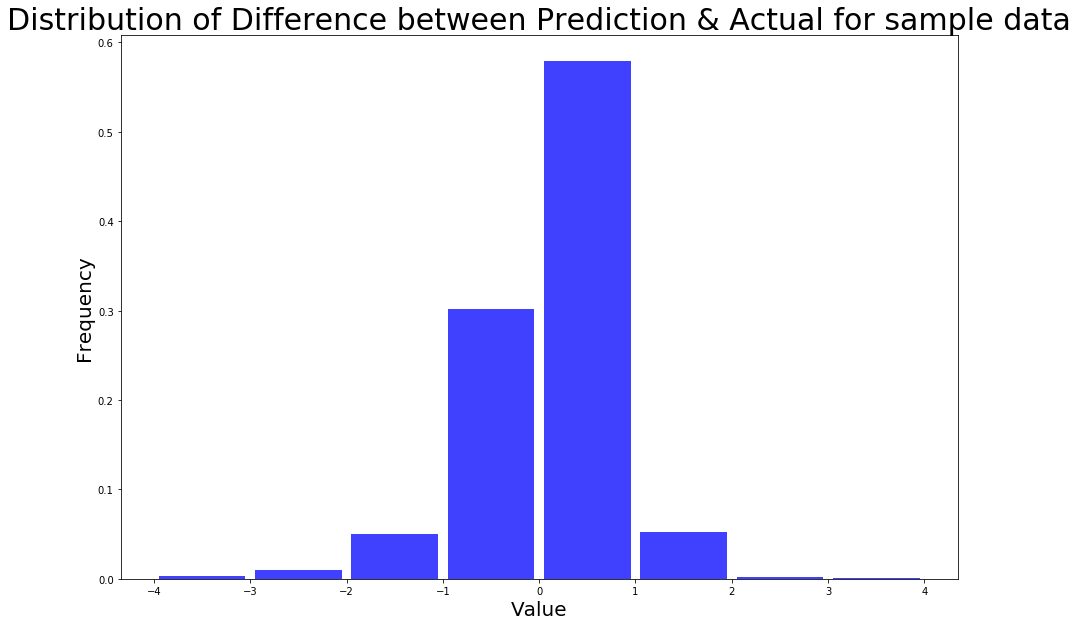

In [46]:
model_pred(p_df_ATM, model_ATM, 'realized_vol')

## Predict out-the-money option data

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.615413,-0.576554,-0.376396,0.14
1,-0.612059,-0.577306,-0.331826,0.13
2,-0.598330,-0.578059,-0.149385,0.12
3,-0.606596,-0.582574,-0.259221,0.06
4,-0.610018,-0.585584,-0.304704,0.02
5,-0.582121,-0.584079,0.066013,0.04
6,-0.567978,-0.583326,0.253971,0.05
7,-0.550279,-0.582574,0.489165,0.06
8,-0.529239,-0.581069,0.768756,0.08
9,-0.518944,-0.579564,0.905568,0.10


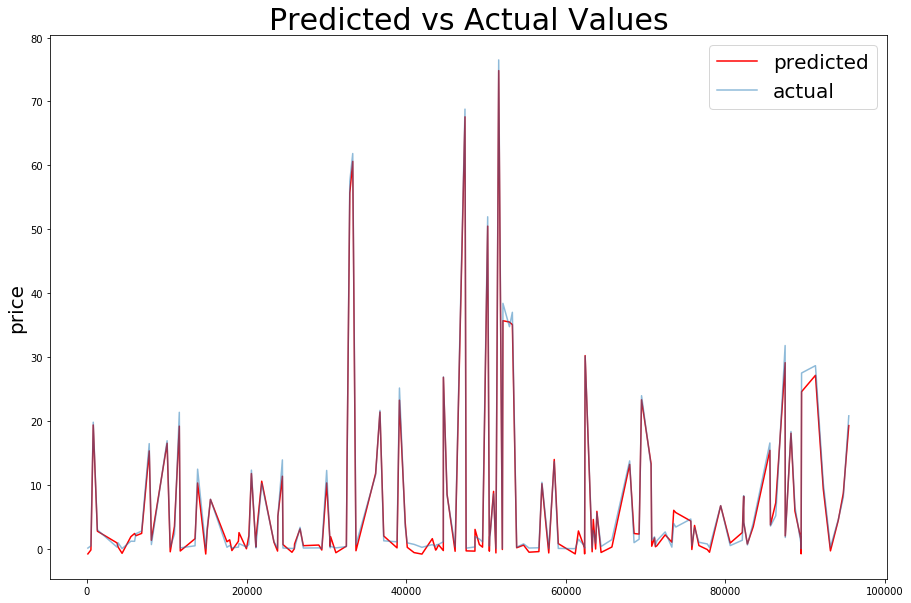

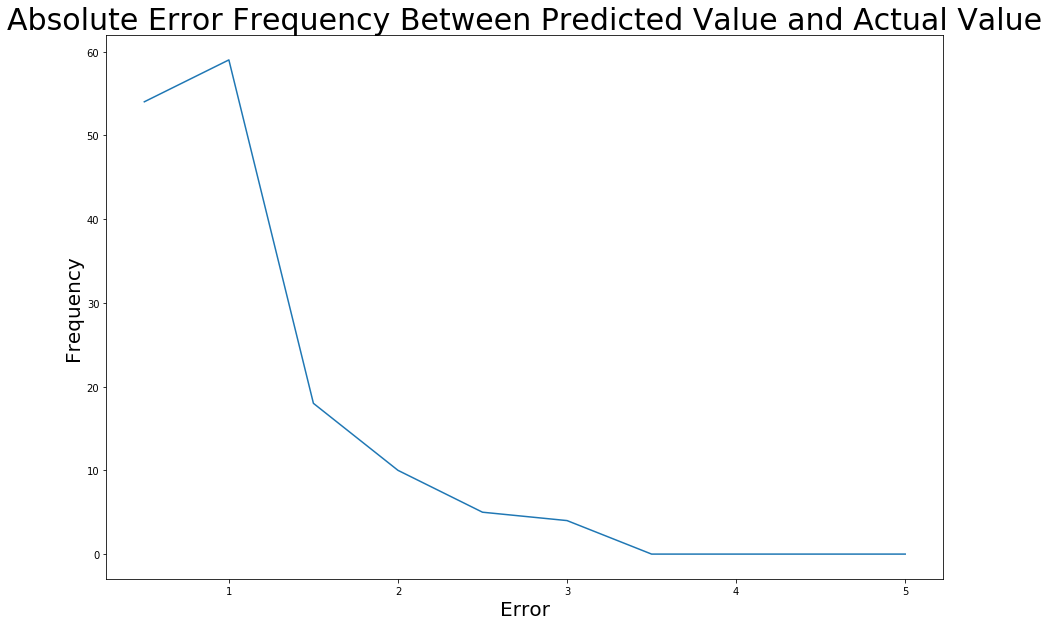

Mean absolute error (MAE):      0.767853
Mean squared error (MSE):       0.975554
R square (R^2):                 0.994476


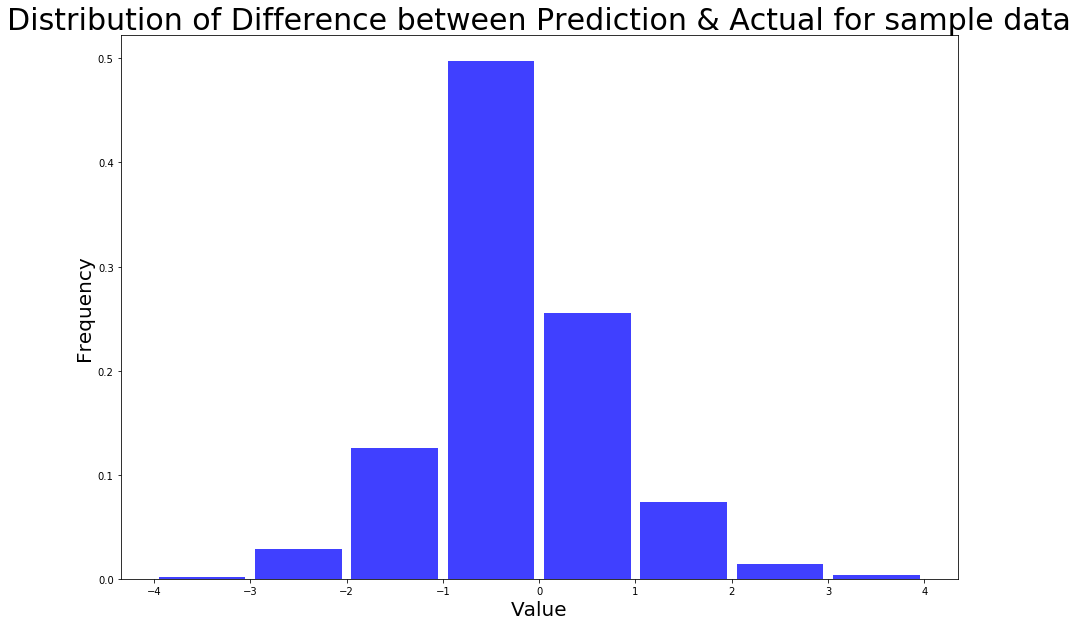

In [50]:
model_pred(p_df_OTM, model_OTM, 'impl_volatility')

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.665766,-0.576554,-1.045528,0.14
1,-0.663227,-0.577306,-1.011794,0.13
2,-0.655349,-0.578059,-0.907104,0.12
3,-0.645007,-0.582574,-0.769662,0.06
4,-0.626389,-0.585584,-0.522256,0.02
5,-0.598363,-0.584079,-0.149818,0.04
6,-0.578597,-0.583326,0.112849,0.05
7,-0.556002,-0.582574,0.413109,0.06
8,-0.533511,-0.581069,0.711991,0.08
9,-0.522255,-0.579564,0.861568,0.10


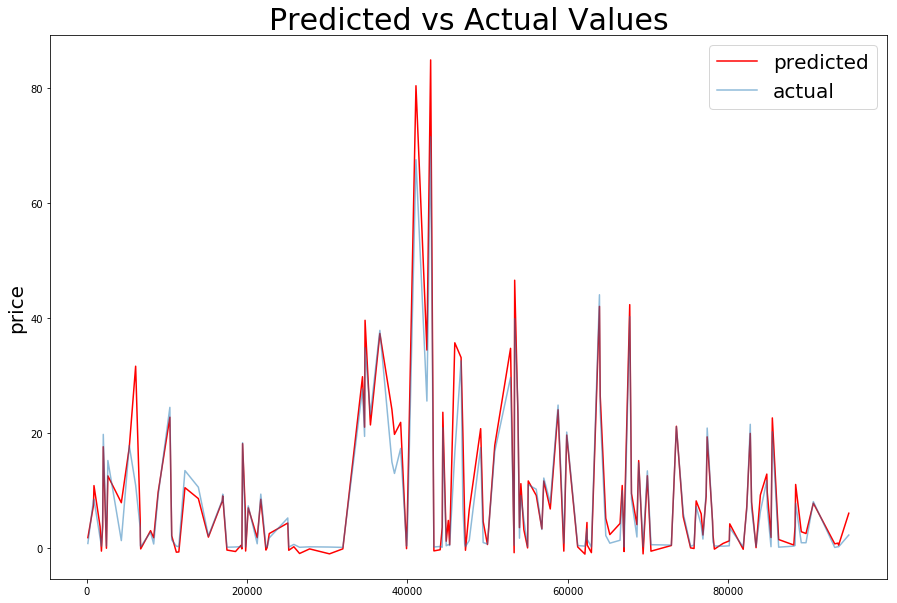

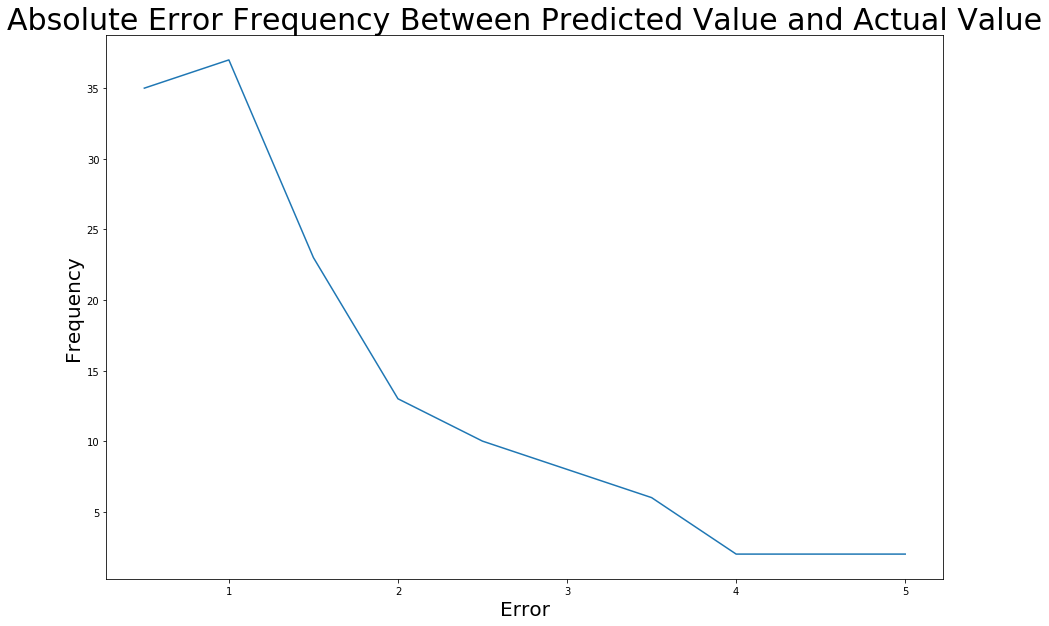

Mean absolute error (MAE):      1.955437
Mean squared error (MSE):       11.665302
R square (R^2):                 0.933943


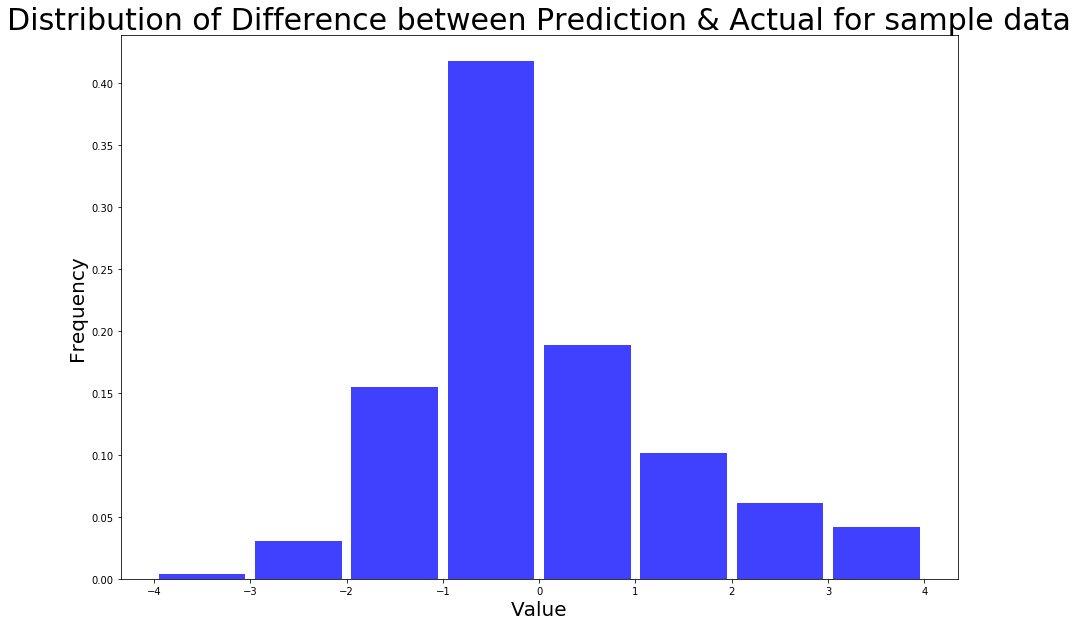

In [47]:
model_pred(p_df_OTM, model_OTM, 'realized_vol')

## Predict the whole option data

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.547480,-0.501290,-0.556689,0.13
1,-0.553730,-0.501290,-0.649610,0.13
2,-0.429582,-0.395682,1.196034,1.70
3,-0.456573,-0.421916,0.794773,1.31
4,-0.484445,-0.446132,0.380412,0.95
5,-0.509772,-0.465639,0.003903,0.66
6,-0.526210,-0.480437,-0.240472,0.44
7,-0.537017,-0.491200,-0.401145,0.28
8,-0.547106,-0.498599,-0.551132,0.17
9,-0.555117,-0.503308,-0.670219,0.10


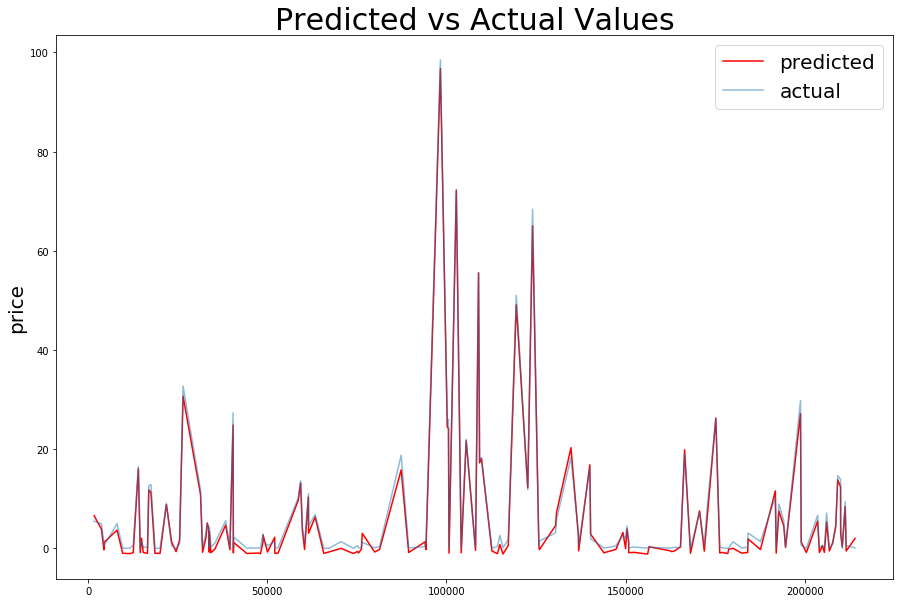

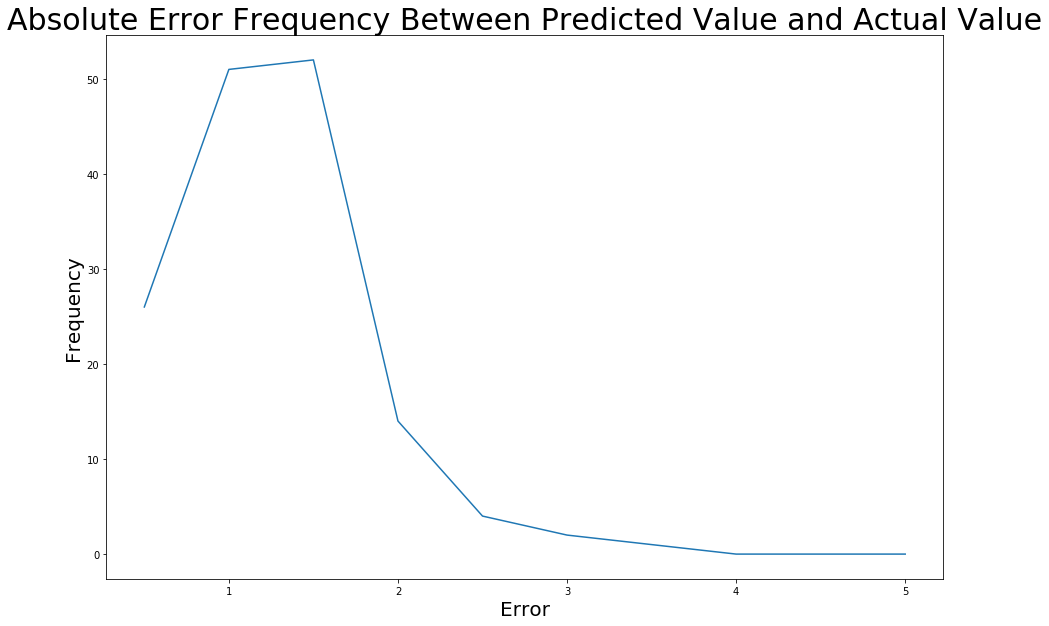

Mean absolute error (MAE):      1.073831
Mean squared error (MSE):       1.619906
R square (R^2):                 0.992670


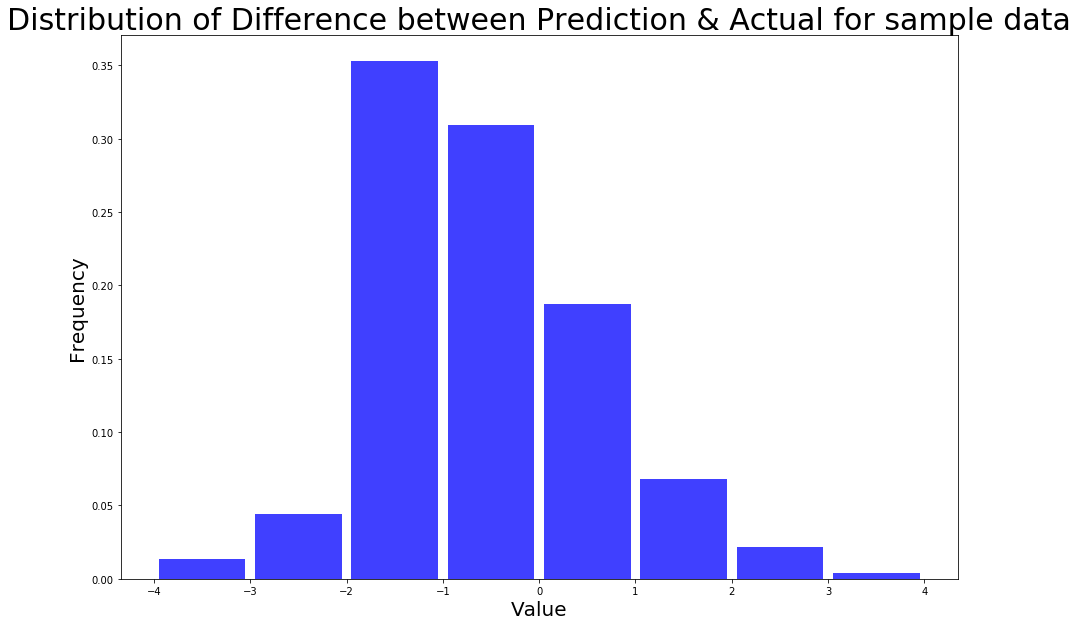

In [48]:
model_pred(p_df, model, 'impl_volatility')

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


,predicted_scale,actual_scale,predict,actual
0,-0.581434,-0.501290,-1.061468,0.13
1,-0.584746,-0.501290,-1.110700,0.13
2,-0.428101,-0.395682,1.218055,1.70
3,-0.455769,-0.421916,0.806728,1.31
4,-0.482885,-0.446132,0.403610,0.95
5,-0.508892,-0.465639,0.016985,0.66
6,-0.525259,-0.480437,-0.226338,0.44
7,-0.535788,-0.491200,-0.382875,0.28
8,-0.545735,-0.498599,-0.530741,0.17
9,-0.554016,-0.503308,-0.653851,0.10


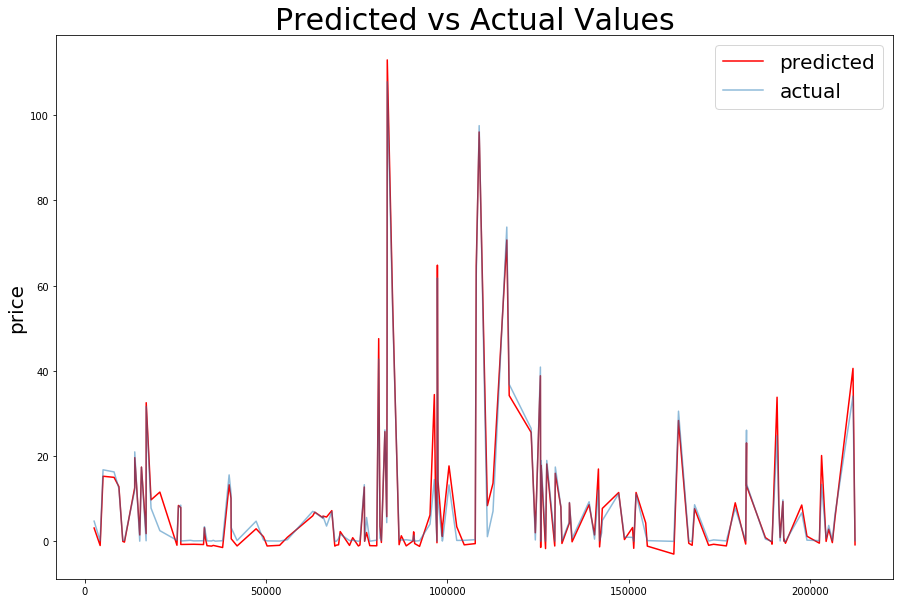

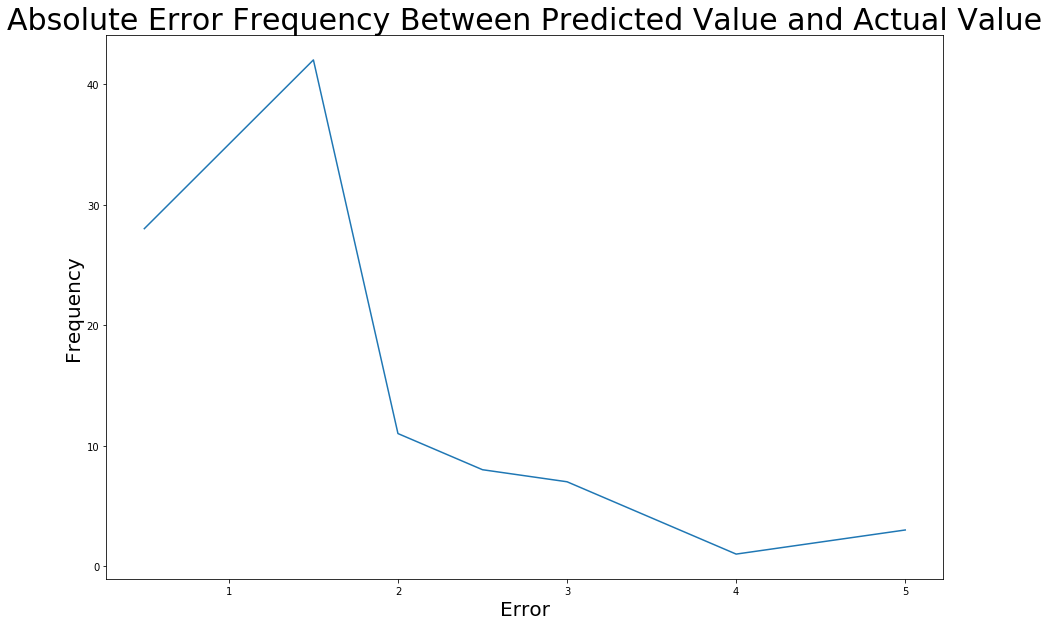

Mean absolute error (MAE):      1.898426
Mean squared error (MSE):       8.911341
R square (R^2):                 0.959679


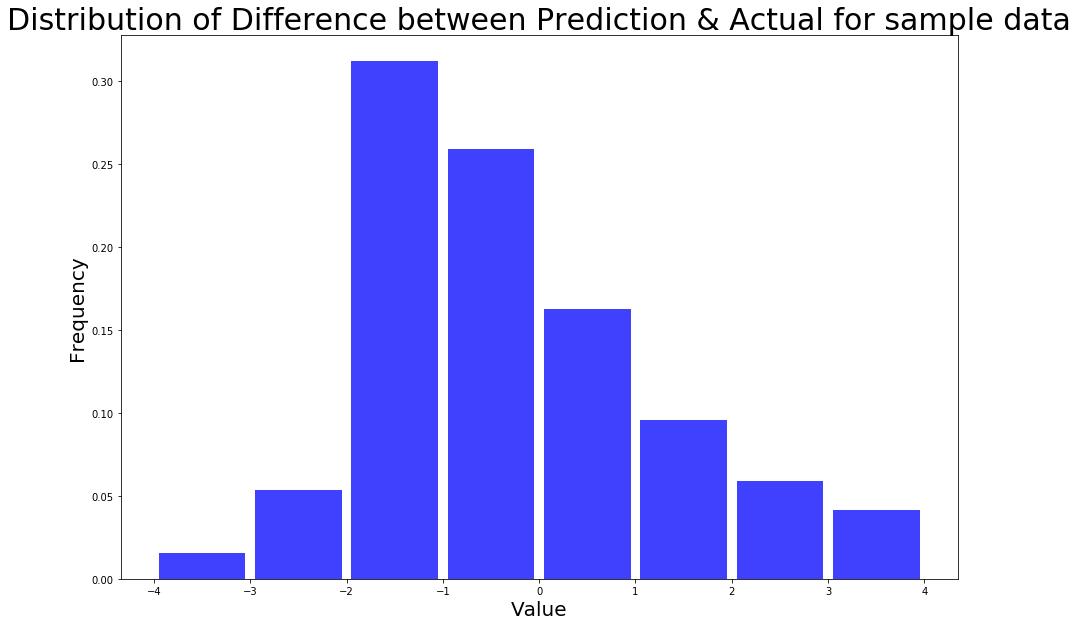

In [49]:
model_pred(p_df, model, 'realized_vol')

## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>